    1. take a look and implement the new variables in data.py
    2. make 1d histogram plots of (for pion and proton)
        a. kinetic energy of simparticle (should be just one value now)
        b. endpoint z position of simparticle
        c. vertex z of simparticle
        d. pdgid of simparticle
        e. number of recoil tracker simhits
        f. number of ecal simhits
        g. number of ecal rechits
        h. then choose one event (e.g. evt 0) and plot info of the recoil tracker simhits for that event:
            i. the pathlength
            ii. the energy deposited (dep)
            iii. the layer of all those simhits
            iv. the time
            v. then choose the simhit at the first layer that you see, then the simhit at the last layer that you see:
                1. plot the difference in z (dz)
                2. plot the difference in r = sqrt(dx^2+ dy^2 + dz^2)
            vi. then for that same event, plot info of the ecal simhits:
                1. the energy deposited (dep)
                2. the layer of all those simhits
                3. then choose the simhit at the first layer that you see, then the simhit at th last layer that you see:
                    a. plot the difference in z (dz)
                    b. plot the difference in r = sqrt(dx^2+ dy^2 + dz^2)
                4. plot the sum of energy deposited and divide it by dz

In [2]:
from coffea import hist
import math
import os
import psutil
import uproot
import awkward as ak
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

from matplotlib import colors
POPTS={'norm':colors.LogNorm(vmin=1,vmax=200)}

In [3]:
with uproot.open("data/protonpion_Sep20/proton_ntuple_Sep20.root") as file:
    print(file["Events"].keys())
    #print(ak.to_list(file["Events"]['Recoil_SimHit_pathLength'].array())[0:15])
    #print(ak.to_list(file["Events"]['Ecal_SimHit_layer'].array())[0:15])
    #print(ak.to_list(file["Events"]['Ecal_SimHit_z'].array())[0:15])
    #print(ak.to_list(file["Events"]['Ecal_SimHit_edep'].array())[0:15])

    #for i in range(0,5):
   #     print(ak.to_list(file["Events"]['Recoil_SimHit_layer'].array())[i])
    #    print(ak.to_list(file["Events"]['Recoil_SimHit_pdgid'].array())[i])
   # print()
    #print(ak.to_list(ak.max(file["Events"]['Ecal_RecHit_layer'].array(), axis=1)))
    

['n_Sim_Particle', 'Sim_Particle_pdgID', 'Sim_Particle_trkID', 'Sim_Particle_mass', 'Sim_Particle_e', 'Sim_Particle_kine', 'Sim_Particle_vx', 'Sim_Particle_vy', 'Sim_Particle_vz', 'Sim_Particle_endx', 'Sim_Particle_endy', 'Sim_Particle_endz', 'Sim_Particle_px', 'Sim_Particle_py', 'Sim_Particle_pz', 'n_Recoil_SimHit', 'Recoil_SimHit_x', 'Recoil_SimHit_y', 'Recoil_SimHit_z', 'Recoil_SimHit_px', 'Recoil_SimHit_py', 'Recoil_SimHit_pz', 'Recoil_SimHit_pdgid', 'Recoil_SimHit_edep', 'Recoil_SimHit_pathLength', 'Recoil_SimHit_layer', 'n_Ecal_SimHit', 'Ecal_SimHit_edep', 'Ecal_SimHit_t', 'Ecal_SimHit_x', 'Ecal_SimHit_y', 'Ecal_SimHit_z', 'Ecal_SimHit_layer', 'n_Ecal_RecHit', 'Ecal_RecHit_amp', 'Ecal_RecHit_e', 'Ecal_RecHit_t', 'Ecal_RecHit_x', 'Ecal_RecHit_y', 'Ecal_RecHit_z', 'Ecal_RecHit_layer']


In [4]:
SimParticle_attrs = ['pdgID','trkID','mass','e','kine','vx','vy','vz','endx','endy','endz','px','py','pz']
RecoilSimHit_attrs = ['x', 'y', 'z', 'px', 'py', 'pz', 'pdgid', 'edep', 'pathLength', 'layer']
EcalSimHit_attrs = ['edep', 't', 'x', 'y', 'z', 'layer']
EcalRecHit_attrs = ['amp', 'e', 't', 'x', 'y', 'z', 'layer']


branches = {
    "Sim_Particle": SimParticle_attrs,
    "Recoil_SimHit": RecoilSimHit_attrs,
    "Ecal_SimHit": EcalSimHit_attrs,
    "Ecal_RecHit": EcalRecHit_attrs,
    "n": ["Sim_Particle", "Recoil_SimHit", "Ecal_SimHit", "Ecal_RecHit"]
}

def getData(fnames="", treeName="Events", chunks=False):
    branchlist = []
    for collection, attrs in branches.items():
        branchlist += [collection+"_"+attr for attr in attrs]
    if chunks: ldmx_dict = uproot.iterate(fnames+":"+treeName, branchlist)
    else: ldmx_dict = uproot.lazy(fnames+":"+treeName, branchlist)
    return ldmx_dict

#Repackages ldmx_dict into new dictionary of dictionaries of form
#ldmx_events={Sim_particle: {pdgID:___, trkID:___,...}, Ecal_RecHit: {amp:___, e:___, ...}, ...}
def repackage(ldmx_dict):
    evt_dict={}
    for collection in branches:    
        coll_dict={}
        for attr in branches[collection]:
            bname = "{}_{}".format(collection, attr)
            coll_dict[attr] = ldmx_dict[bname]
        evt_dict[collection] = ak.zip(coll_dict)        
    ldmx_events = ak.zip(evt_dict, depth_limit=1)
    return ldmx_events


def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x


#---------------------------------- Histogram Functions---------------------------------------------------
Bins={"Sim_Particle": 
        {'pdgID':[50, 200, 2240], 'trkID':[50, 0, 100], 'mass':[20, 0, 940], 'e':[50, 2000, 3500],
         'kine':[50, 0, 2300], 'px':[50, 0, 20], 'py':[50, 0, 20], 'pz':[50, 2000, 3000],
         'endx':[50, 0, 150],'endy':[50, 0, 150], 'endz':[100, 0, 2000], 'vx':[50, 0, 10],
         'vy':[50, 0, 40], 'vz':[50, 0, 50]},
      
      "Recoil_SimHit": {'x':[50,0, 200], 'y':[50,0, 100], 'z':[50,0, 200], 'px':[50,0, 300],
                      'py':[50,0, 400], 'pz':[100,0, 300], 'pdgid':[100,0, 2500], 'edep':[50,0, 0.4],
                      'pathLength':[50,0, 0.5], 'layer':[10,0, 10]},
    
      "Ecal_SimHit": {'edep':[50, 0, 1], 't':[50, 0, 1400], 'x':[50, 0, 300],
                     'y':[50, 0, 300], 'z':[50, 200, 700], 'layer':[35, 0, 34]},
      
      "Ecal_RecHit": 
        {'amp':[50, 0, 3.6], 'e':[50, 0, 100], 't':[20, 0, 1], 
         'x':[50, 0, 250], 'y':[50, 0, 260], 'z':[50, 200, 700], 'layer':[35, 0, 34]},
      
      "n":
        {"Sim_Particle":[50, 0, 100], "Recoil_SimHit":[50, 0, 100], 
         'Ecal_SimHit':[50, 0, 90], 'Ecal_RecHit':[50, 0, 80]}
     }

Labels={"Sim_Particle": 
        {'pdgID':'pdgID', 'trkID':'trkID', 'mass':"Mass [MeV]", 'e':"Energy [MeV]",
         'kine':"Kinetic Energy [MeV]", 'px':r"$p_x$ [MeV]", 'py':r"$p_y$ [MeV]", 'pz':r"$p_z$ [MeV]",
         'endx':r"$End_x$ [mm]",'endy':r"$End_y$ [mm]", 'endz':r"$End_z$ [mm]", 'vx':r"$v_x$ [mm]",
         'vy':r"$v_y$ [mm]", 'vz':r"$v_z$ [mm]"},
        
      "Recoil_SimHit": {'x':'x of Hit [mm]', 'y':'y of Hit [mm]', 'z':'z of Hit [mm]', 'px':'x Momentum of Hit [mm]',
                      'py':'y Momentum of Hit [mm]', 'pz':'z Momentum of Hit [mm]', 'pdgid':'pdgID', 
                      'edep':'Energy Deposited [MeV]', 'pathLength':'Path Length [mm]', 'layer':'Layer'},
    
      "Ecal_SimHit": {'edep':"Energy Deposited [MeV]", 't':"Time of Hit [ns]", 'x':'x of Hit [mm]',
                     'y':'y of Hit [mm]', 'z':'z of Hit [mm]', 'layer':'Layer'},
    
      "Ecal_RecHit": 
        {'amp':"Amplitude [mA]", 'e':"Energy [MeV]", 't':"Time [s]           ", 
         'x': "x [mm]", 'y':"y [mm]", 'z':"z [mm]", 'layer':"Layer"},
        
      "n":
        {'Sim_Particle':("Number of Hits in Event", "Sim_Particle"),
         'Recoil_SimHit':("Number of Hits in Event", "Recoil_SimHit"),   
         'Ecal_RecHit':("Number of Hits in Event", "Ecal_RecHit"),
         'Ecal_SimHit':("Number of Hits in Event", "Ecal_SimHit")} 
         }



#Makes Dictionary of hist.Hist objects in same layout as ldmx_events, where each attr. becomes a key.
#AttrDict must be a dictionary. Bin layout is determined by Bins 3d array, which is indexed with BinAttr
#and BinKey. Preferably this will be mapped out so that individual histograms may be additioned to attr.
#keys. and/or separate binning may be provided. 
def MakeHists(AttrDict, Bins):
    hists={}
    for coll in AttrDict.keys():
        attrHists={}
        for attr in AttrDict[coll]:
            attrHists[attr]=hist.Hist(coll, 
                    axes=(
                    hist.Cat("particle", "Particle"),
                    hist.Bin("e", attr, *(Bins[coll][attr]))
                    ))
            
        hists[coll]=attrHists
    return hists

#def FillHists

In [5]:
hists=MakeHists(branches, Bins)

histsAdd={}

#----------------------------------------------------------------------------------

histsAdd["recoilFLLayerZ"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Difference in z", 100, 0, 200)
                            ))                        

histsAdd["recoilFLLayerR"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Difference in r", 100, 0, 300)
                            ))

histsAdd["ecalFLLayerZ"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Difference in z", 100, 0, 500)
                            ))
                            

histsAdd["ecalFLLayerR"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Difference in r", 100, 0, 500)
                            ))

histsAdd["dE/dz"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "dE/dZ", 100, 0, 0.3)
                            ))


histsAdd["dE/dzStandard"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "dE/dZ Energy Average/Layer Width Average", 100, 0, 0.3)
                            ))

histsAdd["dE/dzSpecific"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "(dE/dZ) per Layer ", 100, 0.001, 0.1),
                            hist.Bin("s", "Layer",34, 0, 34)))
                            

#----------------------------------------------------------------------------------
#------------Sim_Particle
endzSums={}

#------------Recoil_SimHit
histsAdd["recoil_LayerHits"]=hist.Hist("Recoil_SimHits Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Number of Hits", 80, 1, 80),
                            hist.Bin("s", "Layer",10, 1, 11)))

histsAdd["recoil_noSPathLength"]=hist.Hist("Recoil_SimHits Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "(No Scatters) Path Length [mm]", 50, 0, 0.5)))

histsAdd["recoil_LayerEdep"]=hist.Hist("Recoil_SimHits Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Energy Deposited [MeV]", 50, 0, 0.2),
                            hist.Bin("s", "Layer",10, 1, 11)))

histsAdd["recoil_mipAvgLayer"]=hist.Hist("Recoil_SimHits Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "(Energy>MIP) Average [MeV]", 50, 0, 0.25),
                            hist.Bin("s", "Layer",10, 1, 11)))

#-------------Ecal_SimHit
histsAdd["ecalSimHit_LayerHits"]=hist.Hist("Ecal_SimHits Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Number of Hits", 21, 0, 21),
                            hist.Bin("s", "Layer",34, 0, 34)))
histsAdd["ecalSimHit_PathLayerHits"]=hist.Hist("Ecal_SimHits Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Number of Hits", 10, 0, 10),
                            hist.Bin("s", "Layer",34, 0, 34)))

histsAdd["ecalSimHit_LayerEdep"]=hist.Hist("Ecal_SimHits Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Energy Deposited [MeV]", 50, 0, 0.3),
                            hist.Bin("s", "Layer",34, 0, 34)))
    #--------------------------------Layer Average
histsAdd["ecalSimHit_mipAvgLayer"]=hist.Hist("Ecal_SimHits Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "(Energy>MIP) Average [MeV]", 50, 0, 1),
                            hist.Bin("s", "Layer",34, 0, 34)))

histsAdd["ecalSimHit_AvgLayer"]=hist.Hist("Ecal_SimHits Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "(No-MIP Threshold) Energy Average [MeV]", 50, 0, 0.4),
                            hist.Bin("s", "Layer",34, 0, 34)))

#------------Ecal_RecHit
histsAdd["ecalRecHit_LayerHits"]=hist.Hist("Ecal_RecHits Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Number of Hits", 21, 0, 21),
                            hist.Bin("s", "Layer",34, 0, 34)))
histsAdd["ecalRecHit_PathLayerHits"]=hist.Hist("Ecal_RecHits Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Number of Hits", 10, 0, 10),
                            hist.Bin("s", "Layer",34, 0, 34)))

histsAdd["ecalRecHit_LayerEnergy"]=hist.Hist("Ecal_RecHits Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Energy Sum [MeV]", 50, 0, 30),
                            hist.Bin("s", "Layer",34, 0, 34)))
    #-------------------------------Layer Averages 
    
histsAdd["ecalRecHit_mipAvgLayer"]=hist.Hist("Ecal_RecHits Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "(Energy>MIP) Average [MeV]", 50, 0, 100),
                            hist.Bin("s", "Layer", 34, 0, 34)))

histsAdd["ecalRecHit_AvgLayer"]=hist.Hist("Ecal_RecHits Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "(No-MIP Threshold) Energy Average [MeV]", 50, 0, 35),
                            hist.Bin("s", "Layer", 34, 0, 34)))



In [6]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_Particle']
    recoil_simhit = ldmx_events['Recoil_SimHit']
    ecal_simhit = ldmx_events['Ecal_SimHit']
    ecal_rechit = ldmx_events['Ecal_RecHit']
    
    
    
#--------------------------------------- DATA MASKS/MANIPULATION --------------------------------------------
    
    #Determines if data file is one for protons or pions
    par=""
    ID=0
    if ak.all(sim_particle.pdgID==2212):
        par="Proton"
        ID=2212
    elif ak.all(sim_particle.pdgID==211):
        par="Pion"
        ID=211
    
    #Fills all histograms in "hists" that are regular 1D hists of collection attributes
    for coll in ldmx_events.fields:
        for f in ldmx_events[coll].fields:
            hists[coll][f].fill(particle=par, e= flat(getattr(ldmx_events[coll], f)))
            
    #Removes empty events. Why are there empty events?
    recoilEmptyMask=getattr(ldmx_events['n'], "Recoil_SimHit")!=0
    recoil_simhit=recoil_simhit[recoilEmptyMask]

    ecalEmptyMask=getattr(ldmx_events['n'], "Ecal_SimHit")!=0
    ecal_simhit=ecal_simhit[ecalEmptyMask]

    ecalRecEmptyMask=getattr(ldmx_events['n'], "Ecal_RecHit")!=0
    ecal_rechit=ecal_rechit[ecalRecEmptyMask]
    
    recoilIDMask=recoil_simhit.pdgid==ID
    
    #getting rid of hits that occur at later times and earlier layers and looking at path length
    #Path will only contain the first occurence of every tracker hit
    def dontlookback(arr, mask=[[],[]], Start=0):
        if not ak.any(mask): mask=[[True for y in x] for x in arr]#[[True for j in i] if ak.any(i) else [False for j in i] for i in arr]
        Path=[]
        for evt1, evt2 in zip(arr, mask):
            mx=Start
            eventMask=[]
            for hit1, hit2 in zip(evt1, evt2):
                if hit1<=mx: hit2=False
                elif hit1>mx: mx=hit1
                eventMask.append(hit2)
        
            if not any(eventMask): eventMask[0]=True 
            Path.append(eventMask)
        return ak.Array(Path)
    
    recoilPath=dontlookback(recoil_simhit.layer, recoilIDMask)
    ecalPath=dontlookback(ecal_simhit.layer, Start=-1)
    
    #print(ecalPath[0:15])
    #print(pathTotalMask, recoil_simhit.layer, Path)
    
    #'''
    layerZs=np.zeros(34)
    layerSpacing=np.zeros(34)
    layerSpacing[0]=10.0
    
    #Populates layerZs and layerSpacing
    for evt1, evt2 in zip(ecal_simhit.layer[ecalPath], ecal_simhit.z[ecalPath]):
        #In case the event starts with a layer that has not been indexed yet, use the average layer
        #prevLayer=evt1
        for hit1, hit2 in zip(evt1, evt2):
            #layerZs
            if layerZs[hit1]==0: layerZs[hit1]=hit2
            #layerSpacing
            if layerSpacing[hit1]==0 and layerZs[hit1-1]!=0: layerSpacing[hit1]=hit2-layerZs[hit1-1]
            #Break if lists are done being filled
            if layerSpacing[33]!=0: break    
        if layerSpacing[33]!=0: break
            
    
    WidthMap=[]
    for evt in ecal_simhit.layer:
        evtMask=[]
        for hit in evt:
            evtMask.append(layerSpacing[hit])
        WidthMap.append(evtMask)
    
    WidthMap=ak.Array(WidthMap)
    
    #print(ak.to_list(ecal_simhit.layer==3)[0:3])#, WidthMap[ecal_simhit.layer==3])
    #print(ak.to_list(ecalPath & (ecal_simhit.layer==3))[0:3])#, WidthMap[ecalPath])
    #'''
    #Average of distance between layers
    #layerAverage=
    
    #-------------------------------------------------------------------------------------------------------------------- 
    #------------------------------------- First Pass -------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------
    """
    #-------------------------Recoil_SimHit z difference and r difference between first and last layer
    
    recoil_xdif=ak.flatten(recoil_simhit.x[:,-1]-recoil_simhit.x[:,0], axis=None)
    recoil_ydif=ak.flatten(recoil_simhit.y[:,-1]-recoil_simhit.y[:,0], axis=None)
    recoil_zdif=ak.flatten(recoil_simhit.z[:,-1]-recoil_simhit.z[:,0], axis=None)
    recoil_rdif=np.sqrt(recoil_xdif**2+recoil_ydif**2+recoil_zdif**2)
    
    #-------------------------Ecal_SimHit z difference and r difference between first and last layer   
    
    ecal_xdif=ak.flatten(ecal_simhit.x[:,-1]-ecal_simhit.x[:,0], axis=None)
    ecal_ydif=ak.flatten(ecal_simhit.y[:,-1]-ecal_simhit.y[:,0], axis=None)
    ecal_zdif=ak.flatten(ecal_simhit.z[:,-1]-ecal_simhit.z[:,0], axis=None)
    ecal_rdif=np.sqrt(ecal_xdif**2+ecal_ydif**2+ecal_zdif**2)
    
    #-------------------------- dE/dZ Whole Ecal 
    evtESum=ak.sum(ecal_simhit.edep, axis=1)/ecal_zdif
    """
    
    #--------------------------------------------------------------------------------------------------------------------
    #------------------------------------- Second Pass ------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------
    #% of particles on endz regions
    
    Markers=[11, 35, 41]
    preEcalEndz= np.sum(hists["Sim_Particle"]["endz"].values()[(par,)][:12])
    EcalEndz=np.sum(hists["Sim_Particle"]["endz"].values()[(par,)][12:35])
    PostEcalEndz=np.sum(hists["Sim_Particle"]["endz"].values()[(par,)][41:])
    sumEcalEndz=np.sum(hists["Sim_Particle"]["endz"].values()[(par,)])
    endzSums[par]={'preEcal':preEcalEndz/sumEcalEndz, 'Ecal': EcalEndz/sumEcalEndz, 'Tail':PostEcalEndz/sumEcalEndz}
    

    #--------------------------------------------------------------------------------------------------------------------
    #2d plots of layer vs number of hits per layer and layer vs energy deposited for recoil tracker/ ecal simhits/rechits
    
    #---------------Recoil Tracker
    
    for i in range(1,11):
        LayerHits=ak.sum(recoil_simhit.layer==i, axis=1)
        histsAdd["recoil_LayerHits"].fill(particle=par, e=LayerHits, s=i)
        
    
    #for i in range(1,11):
    #    LayerHits=ak.sum(recoil_simhit.layer==i, axis=1)
    #    histsAdd["recoil_PathLayerHits"].fill(particle=par, e=LayerHits, s=i)
    
    for i in range(1,11):
        LayerEdep=ak.sum(recoil_simhit.edep[recoil_simhit.layer==i], axis=1)
        histsAdd["recoil_LayerEdep"].fill(particle=par, e=LayerEdep, s=i)
        
    #---------------Ecal_SimHits
    
    for i in range(0,34):
        LayerHits=ak.sum(ecal_simhit.layer==i, axis=1)
        histsAdd["ecalSimHit_LayerHits"].fill(particle=par, e=LayerHits, s=i)
        
    #for i in range(0,33):
    #    LayerHits=ak.sum(ecal_simhit.layer==i, axis=1)
    #    histsAdd["ecalSimHit_PathLayerHits"].fill(particle=par, e=LayerHits, s=i)
    
    for i in range(0,34):
        LayerEdep=ak.sum(ecal_simhit.edep[ecal_simhit.layer==i], axis=1)
        histsAdd["ecalSimHit_LayerEdep"].fill(particle=par, e=LayerEdep, s=i)
    
    #---------------Ecal_RecHits
    
    for i in range(0,34):
        LayerHits=ak.sum(ecal_rechit.layer==i, axis=1)
        histsAdd["ecalRecHit_LayerHits"].fill(particle=par, e=LayerHits, s=i)
        
    #for i in range(0,33):
    #    LayerHits=ak.sum(ecal_rechit.layer==i, axis=1)
    #    histsAdd["ecalRecHit_LayerHits"].fill(particle=par, e=LayerHits, s=i)
    
    for i in range(0,34):
        LayerEnergy=ak.sum(ecal_rechit.e[ecal_rechit.layer==i], axis=1)
        histsAdd["ecalRecHit_LayerEnergy"].fill(particle=par, e=LayerEnergy, s=i)
    
    #------------------------------------------------------------------------------------------
    #------Recoil_SimHit z,r difference between first and last layer
    #Path=Path[recoilEmptyMask]
    #Path=ak.from_regular(list(filter(lambda x: len(x)>0, emptiesPath)))
    
    #'''
    recoil_xdif=ak.flatten(recoil_simhit.x[recoilPath][:,-1]-recoil_simhit.x[recoilPath][:,0], axis=None)
    recoil_ydif=ak.flatten(recoil_simhit.y[recoilPath][:,-1]-recoil_simhit.y[recoilPath][:,0], axis=None)
    recoil_zdif=ak.flatten(recoil_simhit.z[recoilPath][:,-1]-recoil_simhit.z[recoilPath][:,0], axis=None)
    recoil_rdif=np.sqrt(recoil_xdif**2+recoil_ydif**2+recoil_zdif**2)
    
    #------Ecal_SimHit z, r difference between first and last layer   
    
    ecal_xdif=ak.flatten(ecal_simhit.x[ecalPath][:,-1]-ecal_simhit.x[ecalPath][:,0], axis=None)
    ecal_ydif=ak.flatten(ecal_simhit.y[ecalPath][:,-1]-ecal_simhit.y[ecalPath][:,0], axis=None)
    ecal_zdif=ak.flatten(ecal_simhit.z[ecalPath][:,-1]-ecal_simhit.z[ecalPath][:,0], axis=None)
    ecal_rdif=np.sqrt(ecal_xdif**2+ecal_ydif**2+ecal_zdif**2)
    
    #-------------------------- dE/dZ Whole Ecal 
    mipMask=ecal_simhit.edep>=.13
    
    evtESum=ak.sum(ecal_simhit.edep[ecalPath], axis=1)/ecal_zdif   #Too general
    dedzStandard=ak.flatten(ak.mean(ecal_simhit.edep[ecalPath & mipMask], axis=1)/10.0, axis=0)
    
    for i in range(0,34):
        dedzSpec=ak.flatten(ecal_simhit.edep[ecalPath & mipMask & (ecal_simhit.layer==i)]\
                                /WidthMap[ecalPath & mipMask & (ecal_simhit.layer==i)], axis=None)
        histsAdd['dE/dzSpecific'].fill(particle=par, e=dedzSpec, s=i)
    
    
    #'''
    #----------------------------------------------- MIP Averages ------------------------------------------------
    
    #------------Recoil
    threshold=0
    mx=(max(hists["Recoil_SimHit"]["edep"].values()[(par,)]))
    for i in range(0, len(hists["Recoil_SimHit"]["edep"].values()[(par,)])):
        if hists["Recoil_SimHit"]["edep"].values()[(par,)][i]==mx: threshold=i

    MIP=hists["Recoil_SimHit"]["edep"].axis("e").centers()[threshold-1]
    mipMask=recoil_simhit.edep>=MIP
    
    for i in range(1,11):
        LayerEdep=ak.flatten(ak.mean(recoil_simhit.edep[mipMask & (recoil_simhit.layer==i)], axis=1), axis=0)
        histsAdd["recoil_mipAvgLayer"].fill(particle=par, e=LayerEdep, s=i)
    
    #-------------Ecal_SimHit
    '''
    threshold=0
    mx=(max(hists["Ecal_SimHit"]["edep"].values()[(par,)]))
    for i in range(0, len(hists["Ecal_SimHit"]["edep"].values()[(par,)])):
        if hists["Ecal_SimHit"]["edep"].values()[(par,)][i]==mx: threshold=i

    MIP=hists["Ecal_SimHit"]["edep"].axis("e").centers()[threshold-1]
    '''
    
    mipMask=ecal_simhit.edep>=.13
    
    for i in range(0,34):
        LayerEdep=ak.flatten(ak.mean(ecal_simhit.edep[mipMask & (ecal_simhit.layer==i)], axis=1), axis=0)
        histsAdd["ecalSimHit_mipAvgLayer"].fill(particle=par, e=LayerEdep, s=i)
        
    for i in range(0,34):
        LayerEdep=ak.flatten(ak.mean(ecal_simhit.edep[ecal_simhit.layer==i], axis=1), axis=0)
        histsAdd["ecalSimHit_AvgLayer"].fill(particle=par, e=LayerEdep, s=i)
    
    #-------------Ecal_RecHit
    '''
    threshold=0
    mx=(max(hists["Ecal_RecHit"]["e"].values()[(par,)]))
    for i in range(0, len(hists["Ecal_RecHit"]["e"].values()[(par,)])):
        if hists["Ecal_RecHit"]["e"].values()[(par,)][i]==mx: threshold=i

    MIP=hists["Ecal_RecHit"]["e"].axis("e").centers()[threshold-1]
    '''
    
    mipMask=ecal_rechit.e>=.13
    
    for i in range(0,34):
        LayerEdep=ak.flatten(ak.mean(ecal_rechit.e[mipMask & (ecal_rechit.layer==i)], axis=1), axis=0)
        histsAdd["ecalRecHit_mipAvgLayer"].fill(particle=par, e=LayerEdep, s=i)
        
    for i in range(0,34):
        LayerEdep=ak.flatten(ak.mean(ecal_rechit.e[ecal_rechit.layer==i], axis=1), axis=0)
        histsAdd["ecalRecHit_AvgLayer"].fill(particle=par, e=LayerEdep, s=i)
        
#--------------------------------------- HISTOGRAM FILLING -------------------------------------
    #'''
    histsAdd["recoilFLLayerZ"].fill(particle=par, e=recoil_zdif)
    histsAdd["recoilFLLayerR"].fill(particle=par, e=recoil_rdif)
    histsAdd["ecalFLLayerZ"].fill(particle=par, e=ecal_zdif)
    histsAdd["ecalFLLayerR"].fill(particle=par, e=ecal_rdif)
    histsAdd['dE/dz'].fill(particle=par, e=evtESum)  
    histsAdd['dE/dzStandard'].fill(particle=par, e=dedzStandard)
    
    
    histsAdd["recoil_noSPathLength"].fill(particle=par, e=flat(recoil_simhit.pathLength[recoilPath]))
    
    #'''

In [7]:
ldmx_dict_all = getData(chunks=True, fnames="data/protonpion_Sep20/*.root")

nchunk = 0
for chunk in ldmx_dict_all:
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1


C:\Users\Acer\anaconda3\lib\site-packages\awkward\_connect\_numpy.py:180: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(


process 2


Text(0.5, 1.0, 'Pion')

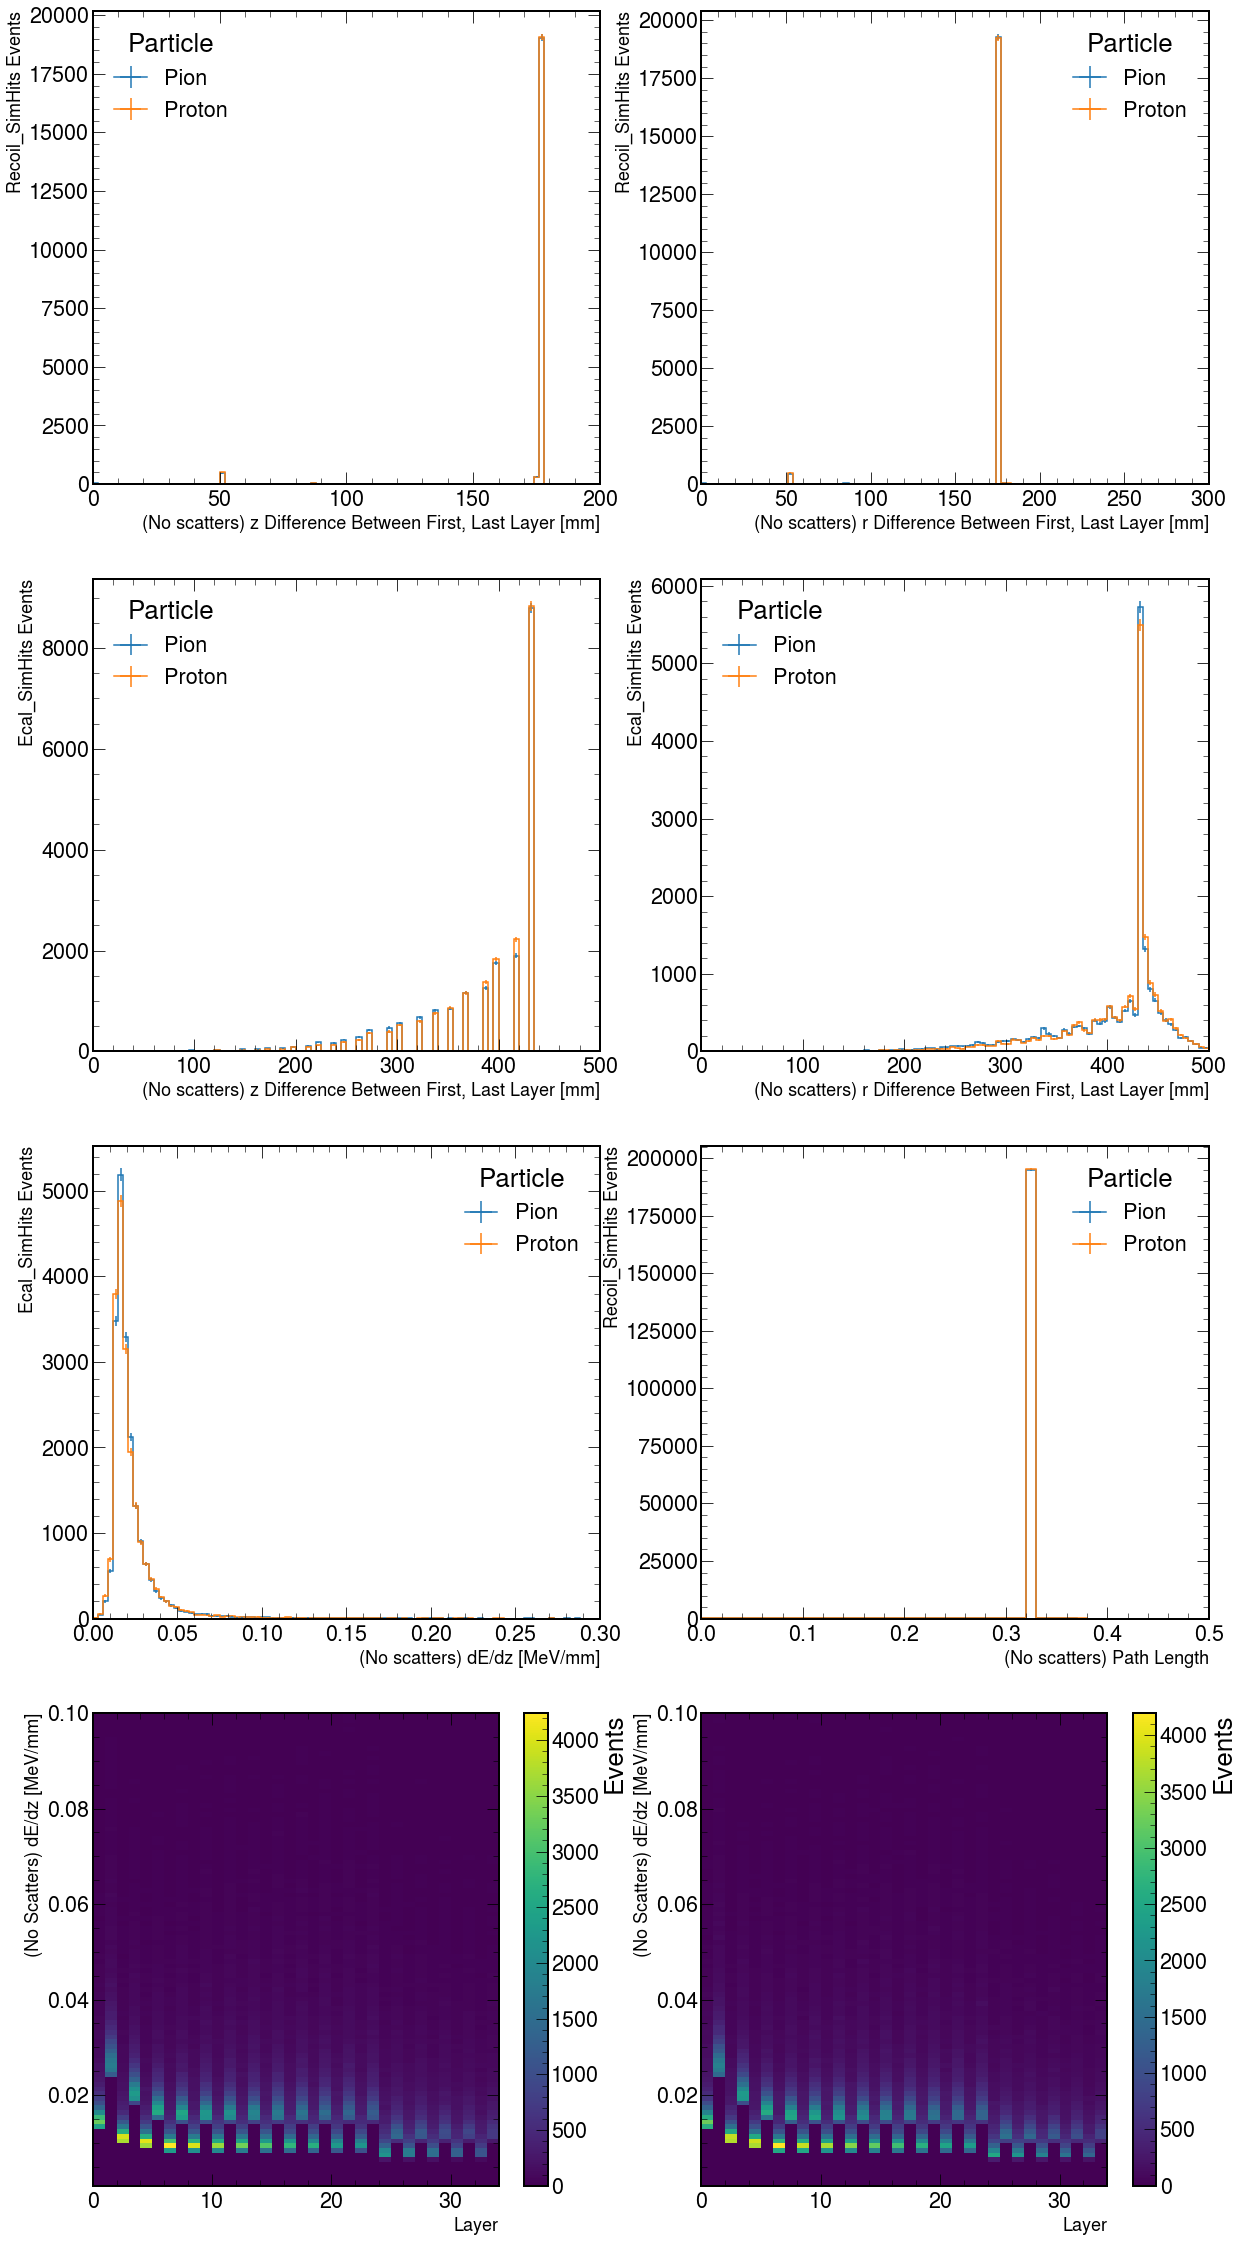

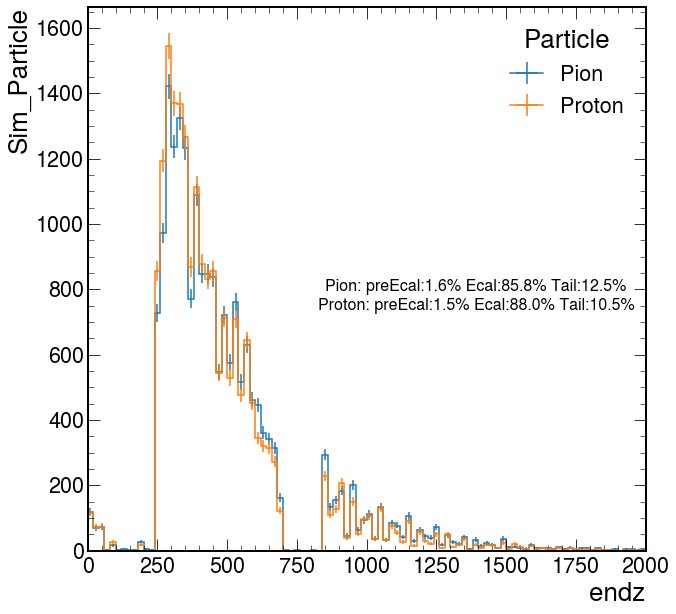

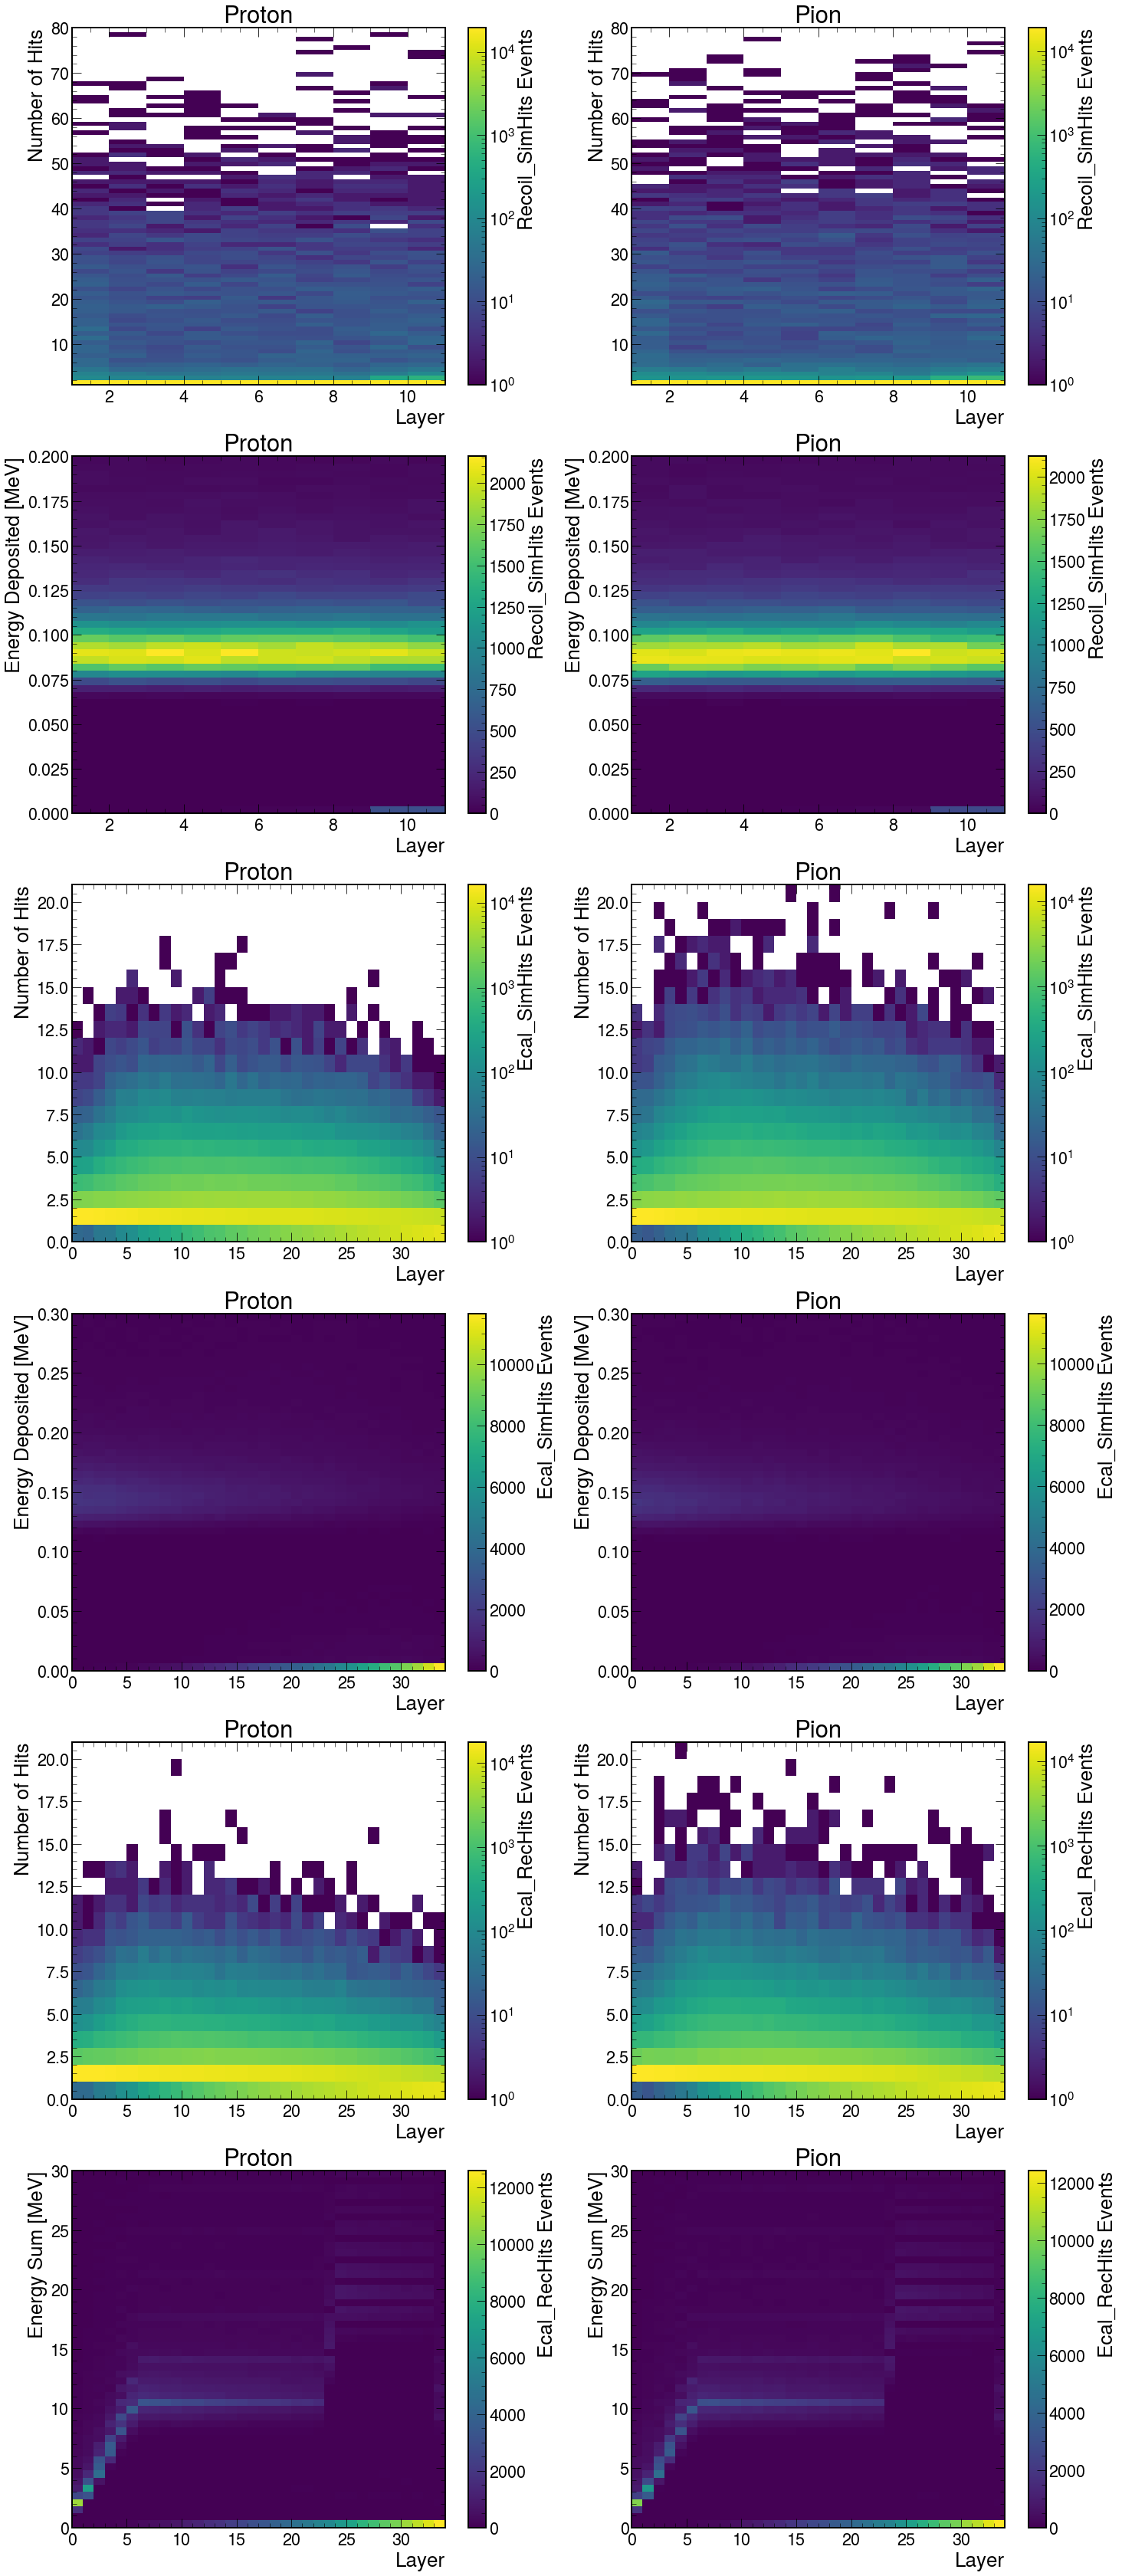

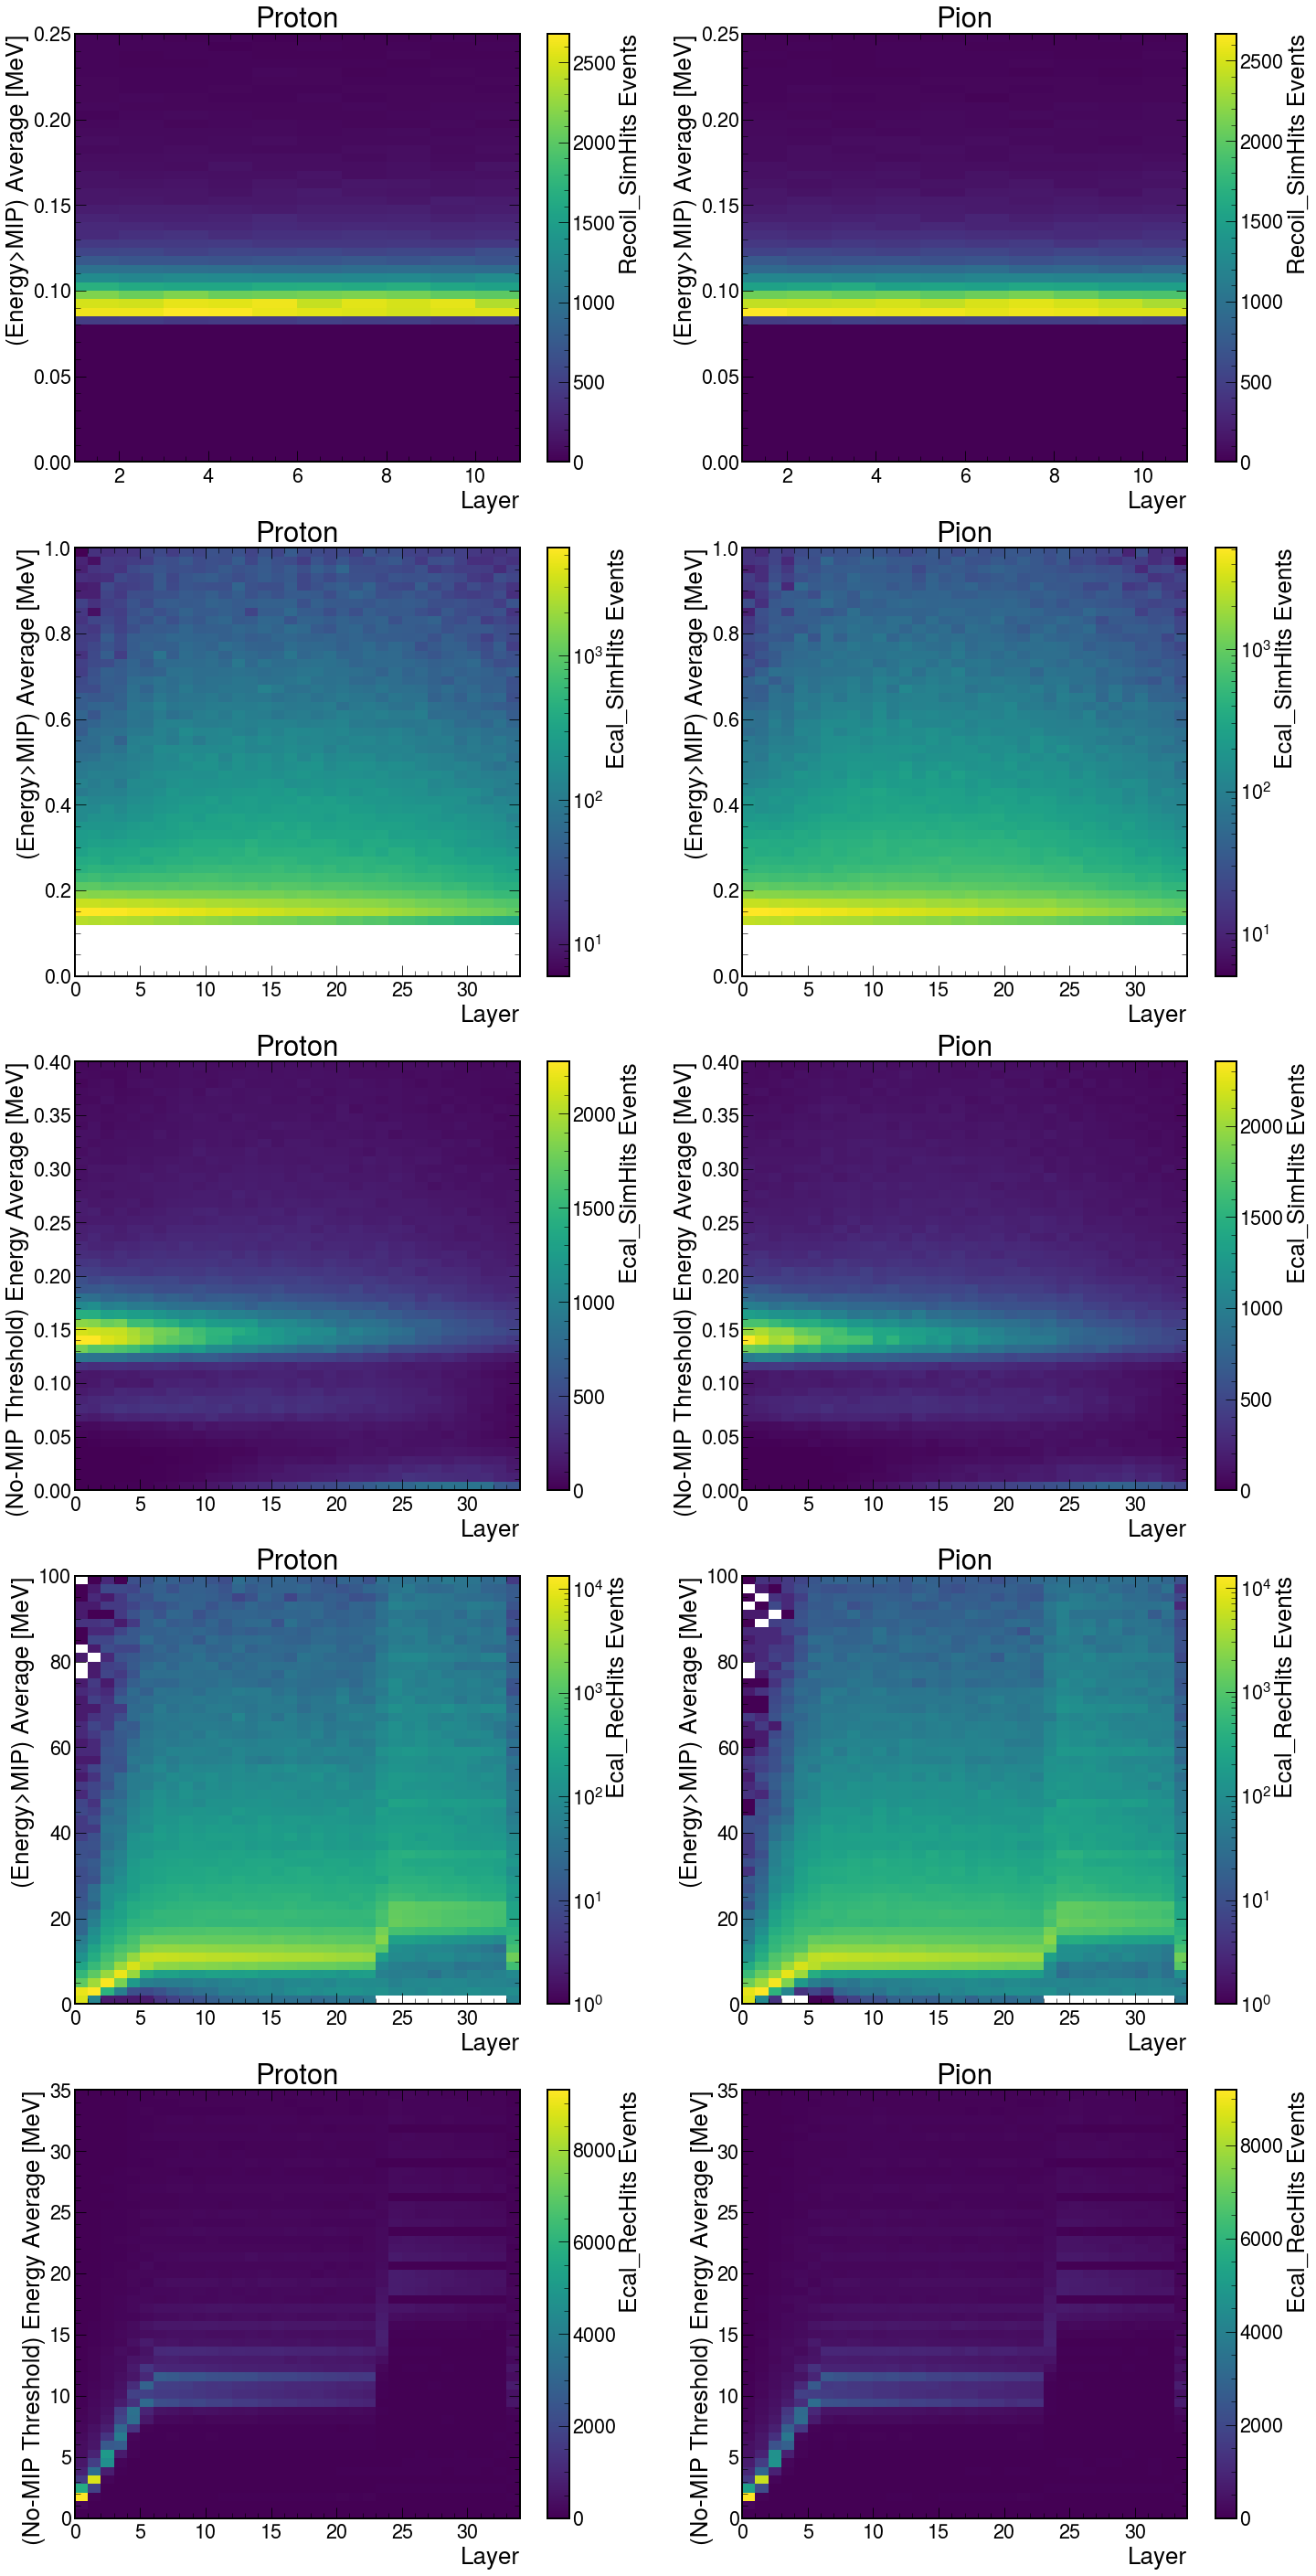

In [8]:
import ipywidgets as widgets

from matplotlib import rcParams
from matplotlib import colors

#------------------------- Plot all graphs in hists --------------------------------
'''
i=0
for coll in hists.keys():
    for key in hists[coll]:
        if i%2==0:
            fig, ax=plt.subplots(ncols=2, figsize=(22,10))
        hist.plot1d(hists[coll][key], ax=ax[i%2], clear=False, overlay="particle")
        
        if (type(Labels[coll][key])==tuple):
            ax[i%2].set_xlabel(Labels[coll][key][0])
            ax[i%2].set_ylabel(Labels[coll][key][1])
        else:
            ax[i%2].set_xlabel(Labels[coll][key])
            
        i+=1
'''
#------------------------- Plotting Widget ----------------------------------------
'''
widlist=[[coll+"-"+attr for attr in branches[coll]] for coll in branches.keys()]
WidList=np.array([])
for i in widlist:
    WidList=np.append(WidList, i)


fig, axW=plt.subplots(figsize=(10,10))

def plott(attr, compare=True):
    coll=attr[:attr.find("-")]
    key=attr[attr.find("-")+1:]
    hist.plot1d(hists[coll][key], ax=axW, overlay="particle", clear=compare)#, legend_opts={'labels':[attr]})
    
    if (type(Labels[coll][key])==tuple):
        axW.set_xlabel(Labels[coll][key][0], fontsize=18)
        axW.set_ylabel(Labels[coll][key][1], fontsize=18)
    else:
        axW.set_xlabel(Labels[coll][key], fontsize=18)
        axW.set_ylabel(coll, size=18)
    #plt.close()
    #display(fig)
   
    
_=widgets.interact(plott, attr=WidList, compare=[("True",0),("False",1)]);
#'''
#--------------------------------------------------------------------------------------------------
#------------------------------------- First Pass -------------------------------------------------
#--------------------------------------------------------------------------------------------------
#'''
fig, ax=plt.subplots(ncols=2,nrows=4, figsize=(20,40))
hist.plot1d(histsAdd['recoilFLLayerZ'], ax=ax[0, 0], clear=False, overlay="particle")
ax[0, 0].set_xlabel("(No scatters) z Difference Between First, Last Layer [mm]", fontsize=18)
ax[0, 0].set_ylabel("Recoil_SimHits Events", fontsize=18)
hist.plot1d(histsAdd['recoilFLLayerR'], ax=ax[0, 1], clear=False, overlay="particle")
ax[0, 1].set_xlabel("(No scatters) r Difference Between First, Last Layer [mm]", fontsize=18)
ax[0, 1].set_ylabel("Recoil_SimHits Events", fontsize=18)

hist.plot1d(histsAdd['ecalFLLayerZ'], ax=ax[1, 0], clear=False, overlay="particle")
ax[1, 0].set_xlabel("(No scatters) z Difference Between First, Last Layer [mm]", fontsize=18)
ax[1, 0].set_ylabel("Ecal_SimHits Events", fontsize=18)
hist.plot1d(histsAdd['ecalFLLayerR'], ax=ax[1, 1], clear=False, overlay="particle")
ax[1, 1].set_xlabel("(No scatters) r Difference Between First, Last Layer [mm]", fontsize=18)
ax[1, 1].set_ylabel("Ecal_SimHits Events", fontsize=18)

hist.plot1d(histsAdd['dE/dz'], ax=ax[2, 0], clear=False, overlay="particle")
ax[2, 0].set_xlabel("(No scatters) dE/dz [MeV/mm]", fontsize=18)
ax[2, 0].set_ylabel("Ecal_SimHits Events", fontsize=18)

hist.plot1d(histsAdd["recoil_noSPathLength"], ax=ax[2,1], clear=False, overlay="particle")
ax[2, 1].set_xlabel("(No scatters) Path Length", fontsize=18)
ax[2, 1].set_ylabel("Recoil_SimHits Events", fontsize=18)


#hist.plot1d(histsAdd['dE/dzStandard'], ax=ax[3,0], clear=False, overlay="particle")
#ax[3, 0].set_xlabel("(No Scatters) dE/dz [MeV/mm]", fontsize=18)
#ax[3, 0].set_ylabel("Ecal_SimHits Events", fontsize=18)

hist.plot2d(histsAdd['dE/dzSpecific']["Proton"].sum("particle"), "s", ax=ax[3,0], clear=True)
ax[3, 0].set_xlabel("Layer", fontsize=18)
ax[3, 0].set_ylabel("(No Scatters) dE/dz [MeV/mm]", fontsize=18)
hist.plot2d(histsAdd['dE/dzSpecific']["Pion"].sum("particle"), "s", ax=ax[3,1], clear=True)
ax[3, 1].set_xlabel("Layer", fontsize=18)
ax[3, 1].set_ylabel("(No Scatters) dE/dz [MeV/mm]", fontsize=18)

#'''
#--------------------------------------------------------------------------------------------------
#---------------------------------- Second Pass ---------------------------------------------------
#--------------------------------------------------------------------------------------------------
formEndzSums=""
for par in endzSums.keys():
    formEndzSums+=par+": "
    for stat in endzSums[par].keys():
        formEndzSums+=stat+":"+str(round(endzSums[par][stat], 3)*100)+"% "
        
    formEndzSums+="\n"

#--------Plots
#------------Endz
fig, ax=plt.subplots( figsize=(10,10))
hist.plot1d(hists['Sim_Particle']["endz"], ax=ax, clear=False, overlay="particle")
plt.suptitle(formEndzSums, x=0.7, y=0.5, fontsize=16, transform=ax.transAxes)

#-----------Layer Plots
fig, ax=plt.subplots(ncols=2, nrows=6, figsize=(24,60))

hist.plot2d(histsAdd["recoil_LayerHits"]["Proton"].sum("particle"), "s", ax=ax[0,0], clear=True, patch_opts={'norm': colors.LogNorm()})
hist.plot2d(histsAdd["recoil_LayerHits"]["Pion"].sum("particle"), "s", ax=ax[0,1], clear=True, patch_opts={'norm': colors.LogNorm()})
ax[0, 0].set_title("Proton")
ax[0, 1].set_title("Pion")

hist.plot2d(histsAdd["recoil_LayerEdep"]["Proton"].sum("particle"), "s", ax=ax[1,0], clear=True)
hist.plot2d(histsAdd["recoil_LayerEdep"]["Pion"].sum("particle"), "s", ax=ax[1,1], clear=True)
ax[1, 0].set_title("Proton")
ax[1, 1].set_title("Pion")

hist.plot2d(histsAdd["ecalSimHit_LayerHits"]["Proton"].sum("particle"), "s", ax=ax[2,0], clear=True, patch_opts={'norm': colors.LogNorm()})
hist.plot2d(histsAdd["ecalSimHit_LayerHits"]["Pion"].sum("particle"), "s", ax=ax[2,1], clear=True, patch_opts={'norm': colors.LogNorm()})
ax[2, 0].set_title("Proton")
ax[2, 1].set_title("Pion")

hist.plot2d(histsAdd["ecalSimHit_LayerEdep"]["Proton"].sum("particle"), "s", ax=ax[3,0], clear=True)
hist.plot2d(histsAdd["ecalSimHit_LayerEdep"]["Pion"].sum("particle"), "s", ax=ax[3,1], clear=True)
ax[3, 0].set_title("Proton")
ax[3, 1].set_title("Pion")

hist.plot2d(histsAdd["ecalRecHit_LayerHits"]["Proton"].sum("particle"), "s", ax=ax[4,0], clear=True, patch_opts={'norm': colors.LogNorm()})
hist.plot2d(histsAdd["ecalRecHit_LayerHits"]["Pion"].sum("particle"), "s", ax=ax[4,1], clear=True, patch_opts={'norm': colors.LogNorm()})
ax[4, 0].set_title("Proton")
ax[4, 1].set_title("Pion")

hist.plot2d(histsAdd["ecalRecHit_LayerEnergy"]["Proton"].sum("particle"), "s", ax=ax[5,0], clear=True)
hist.plot2d(histsAdd["ecalRecHit_LayerEnergy"]["Pion"].sum("particle"), "s", ax=ax[5,1], clear=True)
ax[5, 0].set_title("Proton")
ax[5, 1].set_title("Pion")

#------------------------------------ Layer Energy Averages with MIP
#--------------------Recoil
fig, ax=plt.subplots(ncols=2, nrows=5, figsize=(24,50))
hist.plot2d(histsAdd["recoil_mipAvgLayer"]["Proton"].sum("particle"), "s", ax=ax[0,0], clear=True)
hist.plot2d(histsAdd["recoil_mipAvgLayer"]["Pion"].sum("particle"), "s", ax=ax[0,1], clear=True)
ax[0, 0].set_title("Proton")
ax[0, 1].set_title("Pion")

#--------------------Ecal_sim
hist.plot2d(histsAdd["ecalSimHit_mipAvgLayer"]["Proton"].sum("particle"), "s", ax=ax[1,0], clear=True, patch_opts={'norm': colors.LogNorm()})
hist.plot2d(histsAdd["ecalSimHit_mipAvgLayer"]["Pion"].sum("particle"), "s", ax=ax[1,1], clear=True, patch_opts={'norm': colors.LogNorm()})
ax[1, 0].set_title("Proton")
ax[1, 1].set_title("Pion")

hist.plot2d(histsAdd["ecalSimHit_AvgLayer"]["Proton"].sum("particle"), "s", ax=ax[2,0], clear=True)
hist.plot2d(histsAdd["ecalSimHit_AvgLayer"]["Pion"].sum("particle"), "s", ax=ax[2,1], clear=True)
ax[2, 0].set_title("Proton")
ax[2, 1].set_title("Pion")

#---------------------Ecal_Rec
hist.plot2d(histsAdd["ecalRecHit_mipAvgLayer"]["Proton"].sum("particle"), "s", ax=ax[3,0], clear=True, patch_opts={'norm': colors.LogNorm()})
hist.plot2d(histsAdd["ecalRecHit_mipAvgLayer"]["Pion"].sum("particle"), "s", ax=ax[3,1], clear=True, patch_opts={'norm': colors.LogNorm()})
ax[3, 0].set_title("Proton")
ax[3, 1].set_title("Pion")

hist.plot2d(histsAdd["ecalRecHit_AvgLayer"]["Proton"].sum("particle"), "s", ax=ax[4,0], clear=True)
hist.plot2d(histsAdd["ecalRecHit_AvgLayer"]["Pion"].sum("particle"), "s", ax=ax[4,1], clear=True)
ax[4, 0].set_title("Proton")
ax[4, 1].set_title("Pion")

In [9]:
#print(any([]))
x= [[2,3,4,5], [6,7,8], [9], [2, 9], []]
#y=[x for x in x if x]
#z=[True if x else False for x in x]
a=[[True for j in i]  for i in x]
a2=[[False for j in i] for i in x]
a2[-2][-1]=True
a2[-2][0]=False
        
#print(x)
#print(y)
#print(z)
#print(x=x<=5)
print(a)
print(a2)

print(ak.mean(ak.Array(x)[ak.Array(a) & ak.Array(a2)], axis=1))
#print(ak.Array(x)[ak.Array(z)])

[[True, True, True, True], [True, True, True], [True], [True, True], []]
[[False, False, False, False], [False, False, False], [False], [False, True], []]
[None, None, None, 9, None]


In [10]:
mask=[[]]
maskr=[[True],[True, False]]

print(ak.any(mask))
print(ak.any(maskr))

False
True


In [11]:
print(hists["Sim_Particle"]["endz"].axis("e"))
print(len(histsAdd["dE/dz"].axis("e").centers()), len(histsAdd["dE/dz"].axis("e").edges()), histsAdd["dE/dz"].axis("e").index(0.0001))
    
    
    threshold=0
    mx=(max(hists["Recoil_SimHit"]["edep"].values()[(par,)]))
    for i in range(0, len(hists["Recoil_SimHit"]["edep"].values()[(par,)])):
        if hists["Recoil_SimHit"]["edep"].values()[(par,)][i]==mx: threshold=i

    MIP=hists["Recoil_SimHit"]["edep"].axis("e").centers()[threshold-1]

<Bin (name=e) instance at 0x2124ca09d30>
100 101 1


In [15]:
one = ak.Array([[1.1, 2.2, 3.3], [], [4.4, 5.5], [6.6]])
two = ak.Array([["a", "b", "c"], [], ["d", "e"], ["f"]])
three = ak.Array([[2, 2, 2], [], [2, 2], [2]])
record=ak.zip({'x': one, 'y': two})
record['z']= three

print(ak.to_list(record))
print(len(one[0]))
print(one[True])
print(2-False)

[[{'x': 1.1, 'y': 'a', 'z': 2}, {'x': 2.2, 'y': 'b', 'z': 2}, {'x': 3.3, 'y': 'c', 'z': 2}], [], [{'x': 4.4, 'y': 'd', 'z': 2}, {'x': 5.5, 'y': 'e', 'z': 2}], [{'x': 6.6, 'y': 'f', 'z': 2}]]
3
[]
2
